In [ ]:
! pip uninstall pulse2percept -y
! cd pulse2percept && pip install -r requirements.txt && pip install -r requirements-dev.txt && pip install -e .
! pip install tqdm 

In [7]:
! pip install Pillow
! pip install Pandas
! pip install sklearn

# Generating Datasets using python multiprocessing

In [1]:
import pulse2percept as p2p
from prima import * 
%matplotlib inline 
import matplotlib.pyplot as plt 

In [2]:
"""
    utilities for generating percepts for a given model/implant with one stimulus point at each pixel
    of magnitude 10
"""
from tqdm import tqdm 
from multiprocessing import Pool

BASE_CURRENT_CONSTANT = 10

def generate_dataset_helper(argpack):
    model, implant, stim_dim, idx = argpack
    stim = np.zeros(stim_dim)
    stim[idx] = BASE_CURRENT_CONSTANT
    implant.stim = stim
    percept = model.predict_percept(implant)
    return percept

def generate_dataset_fast(model, implant, stim_dim, j=8):
    with Pool(j) as p:
        generator = p.imap(generate_dataset_helper, [(model, implant, stim_dim, idx) for idx in range(0, stim_dim)])
        return list(tqdm(generator, total=stim_dim))


def plot_percept(ax, model, percept, title='Predicted percept'):
    ax.imshow(percept, cmap='gray')
    ax.set_xticks(np.linspace(0, percept.shape[1], num=5))
    ax.set_xticklabels(np.linspace(*model.xrange, num=5))
    ax.set_xlabel('x (dva)')
    ax.set_yticks(np.linspace(0, percept.shape[0], num=5))
    ax.set_yticklabels(np.linspace(*model.yrange, num=5))
    ax.set_ylabel('y (dva)')
    ax.set_title(title)
    

In [14]:
# utility for running PCA on some data 
from sklearn import decomposition
from sklearn import datasets
import numpy as np
import pandas as pd 
from sklearn.preprocessing import *

def run_pca(dataset, percentage=0.95):
    percepts = normalize(np.array([obj.flatten() for obj in dataset]))
    percepts_pca = decomposition.PCA(percentage)
    percepts_pca.fit(percepts)
    components = percepts_pca.transform(percepts)
    projected = percepts_pca.inverse_transform(components)
    return components, projected

In [ ]:
# example, generate percepts for ArgusII using AxonMapModel

# model = p2p.models.AxonMapModel(rho=100, axlambda=200)
# model.engine = 'serial'
# model.build()
# implant = p2p.implants.ArgusII()
# output_percepts = generate_dataset_fast(model, implant, 60)

# import pickle
# if output_percepts and len(output_percepts) > 0:
#     with open("./data/ArgusII_percepts.pickle", "wb") as f:
#         pickle.dump(output_percepts, f)

# print("Done generating percepts")

In [ ]:
# example, generate percepts for Prima using ScoreboardModel

# from prima import * 
# model = p2p.models.ScoreboardModel(rho=100)
# model.engine = 'serial'
# model.build()
# implant = Prima()
# output_percepts = generate_dataset_fast(model, implant, 400, j=12)
# if output_percepts:
#     with open("./data/Prima20x20_ScoreboardModel_percepts.pickle", "wb") as f:
#         pickle.dump(output_percepts, f)

## Dataset for Scoreboard w/Prima and Argus w/different values of rho

In [4]:
rhos = [25, 50, 75, 100, 125, 150, 200, 300]

rho: 25 argus scoreboard
rho: 25 prima scoreboard
rho: 50 argus scoreboard
rho: 50 prima scoreboard
rho: 75 argus scoreboard
rho: 75 prima scoreboard
rho: 100 argus scoreboard
rho: 100 prima scoreboard
rho: 125 argus scoreboard
rho: 125 prima scoreboard
rho: 150 argus scoreboard
rho: 150 prima scoreboard
rho: 200 argus scoreboard
rho: 200 prima scoreboard
rho: 300 argus scoreboard
rho: 300 prima scoreboard


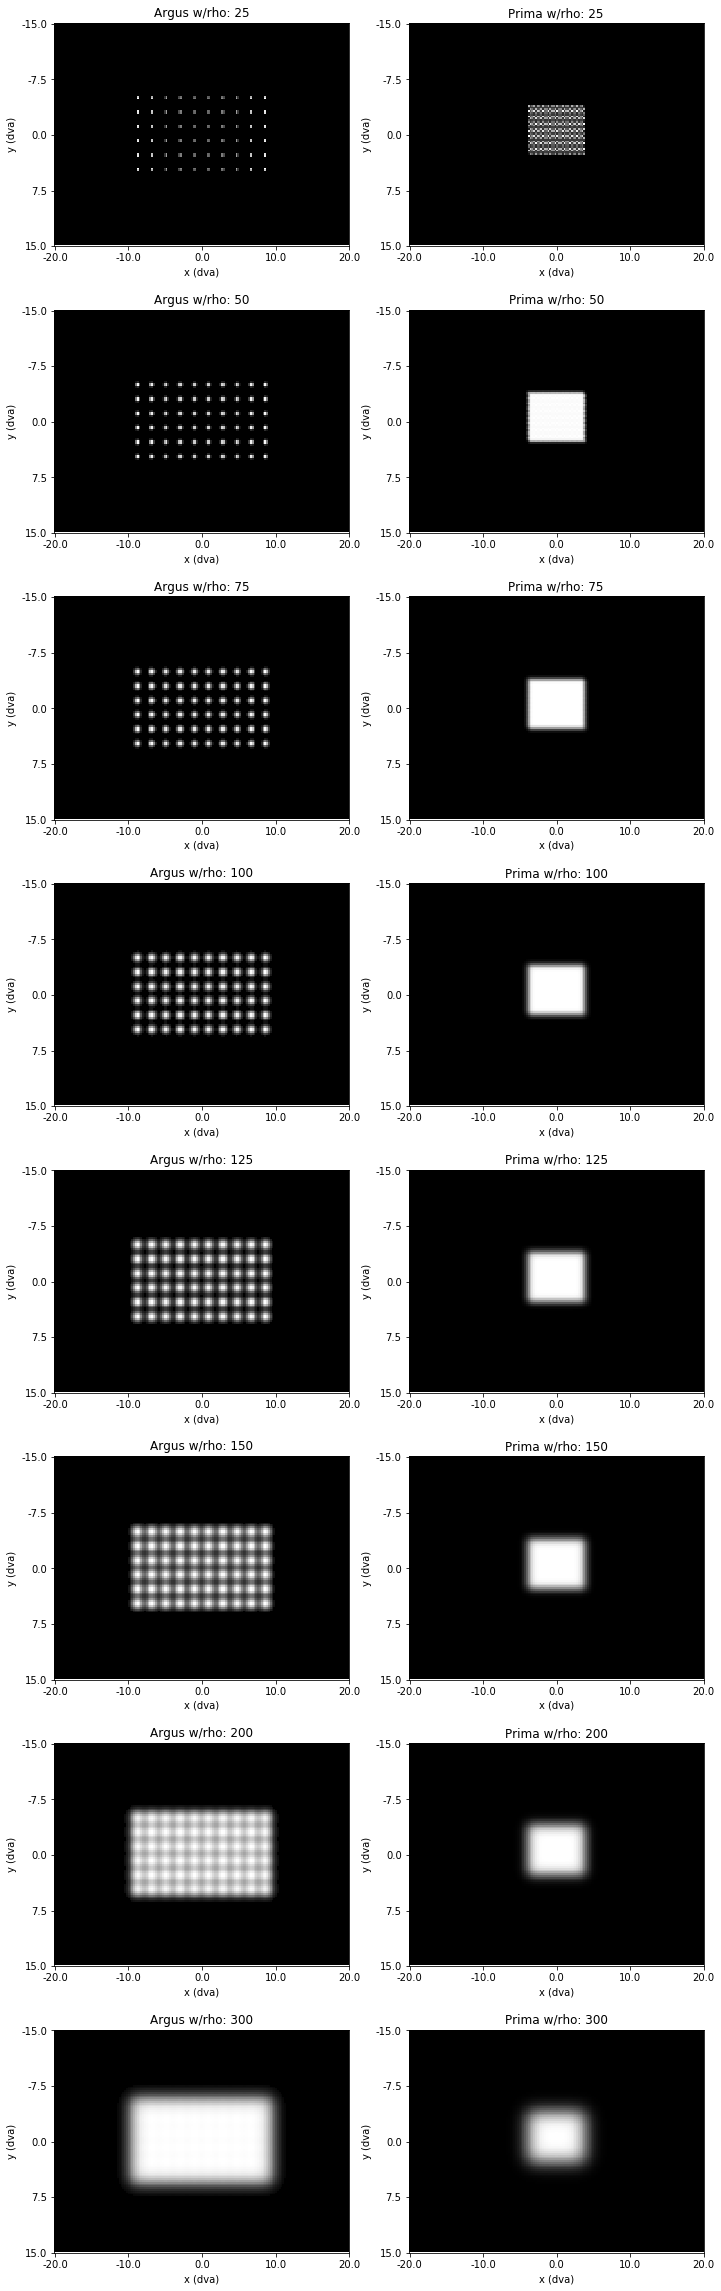

In [38]:
fig, axs = plt.subplots(len(rhos), 2, constrained_layout=False, figsize=(10, 4 * len(rhos)))

#
# PLOT THE ARGUS AND PRIMA IMPLANTS FOR VARIOUS VALUES OF RHO USING SCOREBOARD MODEL 
# SO THAT WE CAN VISUALIZE WHAT CHANGING VALUES FOR RHO DOES
#
for rho, (ax_argus, ax_prima) in zip(rhos, axs):
    model = p2p.models.ScoreboardModel(rho=rho)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("rho: %d argus scoreboard" % rho)
    implant = p2p.implants.ArgusII()
    implant.stim = BASE_CURRENT_CONSTANT * np.ones(60)
    
    percept = model.predict_percept(implant)
    plot_percept(ax_argus, model, percept, "Argus w/rho: %d" % rho)
    
    # simulate Prima
    print("rho: %d prima scoreboard" % rho)
    implant = Prima()
    implant.stim = BASE_CURRENT_CONSTANT * np.ones(400)
    
    percept = model.predict_percept(implant)
    plot_percept(ax_prima, model, percept, "Prima w/rho: %d" % rho)

fig.tight_layout()

In [36]:
import gzip
import pickle 
import os 
#
# GENERATE DATASET OF PERCEPTS FROM THE ABOVE PLOTTING
# !! WARNING !! THIS WILL TAKE A VERY LONG TIME ON MOST CPUs
#
basedir = "./data/changing_rho_experiments/"
try:
    os.makedirs(basedir)
except: pass 

print("generating percept sets for values of rho: " + str(rhos))
for rho in rhos:
    model = p2p.models.ScoreboardModel(rho=rho)
    model.engine = 'serial'
    model.build()
    
    # simulate ArgusII
    print("rho: %d argus scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)):
        implant = p2p.implants.ArgusII()
        percepts = generate_dataset_fast(model, implant, 60, j=8)
        with gzip.open(os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)
            
    # simulate AlphaIMS
""" # far to slow to reasonably run
    print("rho: %d alphaims scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho)):
        implant = p2p.implants.AlphaIMS()
        percepts = generate_dataset_fast(model, implant, 37 ** 2, j=8)
        with gzip.open(os.path.join(basedir, "alphaims_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)
"""
    
    # simulate ArgusII
    print("rho: %d prima scoreboard" % rho)
    if not os.path.exists(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)):
        implant = Prima()
        percepts = generate_dataset_fast(model, implant, 400, j=8)
        with gzip.open(os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho), "wb") as f:
            pickle.dump(percepts, f)


generating percept sets for values of rho: [25, 50, 75, 100, 125, 150, 200, 300]
rho: 25 argus scoreboard
rho: 25 alphaims scoreboard




  0%|          | 0/1369 [00:00<?, ?it/s]

  0%|          | 1/1369 [01:03<24:08:01, 63.51s/it]

  0%|          | 4/1369 [01:03<16:51:43, 44.47s/it]

  0%|          | 6/1369 [01:03<11:47:46, 31.16s/it]

  1%|          | 9/1369 [02:30<11:30:50, 30.48s/it]

  1%|          | 10/1369 [02:31<8:10:43, 21.67s/it]

  1%|          | 11/1369 [02:32<5:48:16, 15.39s/it]

  1%|          | 16/1369 [02:33<4:04:02, 10.82s/it]

  1%|          | 17/1369 [04:01<12:44:33, 33.93s/it]

  1%|▏         | 18/1369 [04:02<9:05:54, 24.24s/it] 

  1%|▏         | 19/1369 [04:03<6:27:27, 17.22s/it]

  2%|▏         | 23/1369 [04:03<4:30:52, 12.07s/it]

  2%|▏         | 24/1369 [04:04<3:15:57,  8.74s/it]

  2%|▏         | 25/1369 [05:26<11:29:27, 30.78s/it]

  2%|▏         | 26/1369 [05:28<8:13:47, 22.06s/it] 

  2%|▏         | 27/1369 [05:29<5:52:09, 15.74s/it]

  2%|▏         | 29/1369 [05:30<4:07:28, 11.08s/it]

  2%|▏         | 31/1369 [05:30<2:55:22,  7.86s/it]

  2%|▏         | 32/1369 [05:31<2:07:25,  5.72s/it]

 23%|██▎       | 317/1369 [1:04:53<1:50:37,  6.31s/it]

 23%|██▎       | 318/1369 [1:04:57<1:38:21,  5.61s/it]

 23%|██▎       | 319/1369 [1:05:06<1:56:21,  6.65s/it]

 23%|██▎       | 320/1369 [1:05:25<3:02:06, 10.42s/it]

 23%|██▎       | 321/1369 [1:06:23<7:10:18, 24.64s/it]

 24%|██▎       | 322/1369 [1:06:24<5:07:46, 17.64s/it]

 24%|██▎       | 323/1369 [1:06:24<3:36:57, 12.44s/it]

 24%|██▎       | 324/1369 [1:06:26<2:40:11,  9.20s/it]

 24%|██▎       | 325/1369 [1:06:27<1:55:16,  6.62s/it]

 24%|██▍       | 326/1369 [1:06:31<1:44:06,  5.99s/it]

 24%|██▍       | 327/1369 [1:06:38<1:51:12,  6.40s/it]

 24%|██▍       | 328/1369 [1:06:56<2:46:42,  9.61s/it]

 24%|██▍       | 329/1369 [1:07:48<6:30:15, 22.51s/it]

 24%|██▍       | 330/1369 [1:07:49<4:35:55, 15.93s/it]

 24%|██▍       | 331/1369 [1:07:50<3:17:23, 11.41s/it]

 24%|██▍       | 332/1369 [1:07:51<2:26:01,  8.45s/it]

 24%|██▍       | 333/1369 [1:07:52<1:48:12,  6.27s/it]

 24%|██▍       | 334/1369 [1:07:56<1:33:22,  5.4

 43%|████▎     | 593/1369 [2:01:08<5:04:43, 23.56s/it]

 43%|████▎     | 594/1369 [2:01:09<3:38:06, 16.89s/it]

 44%|████▎     | 596/1369 [2:01:17<2:48:23, 13.07s/it]

 44%|████▎     | 597/1369 [2:01:23<2:18:59, 10.80s/it]

 44%|████▎     | 598/1369 [2:01:40<2:41:49, 12.59s/it]

 44%|████▍     | 599/1369 [2:01:41<1:59:55,  9.34s/it]

 44%|████▍     | 600/1369 [2:02:16<3:38:08, 17.02s/it]

 44%|████▍     | 601/1369 [2:02:44<4:18:50, 20.22s/it]

 44%|████▍     | 602/1369 [2:02:44<3:02:09, 14.25s/it]

 44%|████▍     | 604/1369 [2:02:50<2:19:08, 10.91s/it]

 44%|████▍     | 605/1369 [2:02:56<1:58:59,  9.35s/it]

 44%|████▍     | 606/1369 [2:03:11<2:20:44, 11.07s/it]

 44%|████▍     | 607/1369 [2:03:14<1:48:50,  8.57s/it]

 44%|████▍     | 608/1369 [2:03:48<3:24:26, 16.12s/it]

 44%|████▍     | 609/1369 [2:04:15<4:06:34, 19.47s/it]

 45%|████▍     | 610/1369 [2:04:15<2:52:49, 13.66s/it]

 45%|████▍     | 612/1369 [2:04:22<2:13:04, 10.55s/it]

 45%|████▍     | 613/1369 [2:04:27<1:52:51,  8.9

 64%|██████▍   | 873/1369 [2:49:25<1:57:03, 14.16s/it]

 64%|██████▍   | 874/1369 [2:49:28<1:29:21, 10.83s/it]

 64%|██████▍   | 875/1369 [2:49:36<1:21:17,  9.87s/it]

 64%|██████▍   | 876/1369 [2:49:37<58:36,  7.13s/it]  

 64%|██████▍   | 877/1369 [2:49:46<1:04:49,  7.90s/it]

 64%|██████▍   | 878/1369 [2:49:56<1:09:00,  8.43s/it]

 64%|██████▍   | 879/1369 [2:49:57<50:57,  6.24s/it]  

 64%|██████▍   | 880/1369 [2:50:43<2:27:33, 18.11s/it]

 64%|██████▍   | 881/1369 [2:50:49<1:58:23, 14.56s/it]

 64%|██████▍   | 882/1369 [2:50:53<1:31:45, 11.31s/it]

 64%|██████▍   | 883/1369 [2:51:00<1:22:35, 10.20s/it]

 65%|██████▍   | 884/1369 [2:51:01<58:09,  7.20s/it]  

 65%|██████▍   | 885/1369 [2:51:12<1:07:41,  8.39s/it]

 65%|██████▍   | 886/1369 [2:51:19<1:05:52,  8.18s/it]

 65%|██████▍   | 887/1369 [2:51:21<49:55,  6.21s/it]  

 65%|██████▍   | 888/1369 [2:52:04<2:17:20, 17.13s/it]

 65%|██████▍   | 889/1369 [2:52:10<1:51:42, 13.96s/it]

 65%|██████▌   | 890/1369 [2:52:14<1:28:00, 11.0

 83%|████████▎ | 1142/1369 [3:35:01<26:56,  7.12s/it]

 83%|████████▎ | 1143/1369 [3:35:05<22:55,  6.09s/it]

 84%|████████▎ | 1144/1369 [3:35:33<47:16, 12.61s/it]

 84%|████████▎ | 1145/1369 [3:35:47<48:36, 13.02s/it]

 84%|████████▎ | 1146/1369 [3:35:56<43:41, 11.76s/it]

 84%|████████▍ | 1147/1369 [3:36:07<43:01, 11.63s/it]

 84%|████████▍ | 1148/1369 [3:36:19<43:42, 11.87s/it]

 84%|████████▍ | 1149/1369 [3:36:20<31:44,  8.66s/it]

 84%|████████▍ | 1150/1369 [3:36:23<25:25,  6.97s/it]

 84%|████████▍ | 1151/1369 [3:36:27<22:02,  6.07s/it]

 84%|████████▍ | 1152/1369 [3:36:55<45:31, 12.59s/it]

 84%|████████▍ | 1153/1369 [3:37:09<46:39, 12.96s/it]

 84%|████████▍ | 1154/1369 [3:37:18<41:44, 11.65s/it]

 84%|████████▍ | 1155/1369 [3:37:29<41:14, 11.56s/it]

 84%|████████▍ | 1156/1369 [3:37:42<42:58, 12.10s/it]

 85%|████████▍ | 1157/1369 [3:37:43<30:14,  8.56s/it]

 85%|████████▍ | 1158/1369 [3:37:46<24:03,  6.84s/it]

 85%|████████▍ | 1159/1369 [3:37:51<22:08,  6.32s/it]

 85%|█████

rho: 25 prima scoreboard
rho: 50 argus scoreboard
rho: 50 alphaims scoreboard




  0%|          | 0/1369 [00:00<?, ?it/s]Process ForkPoolWorker-214:
Process ForkPoolWorker-216:
Process ForkPoolWorker-220:
Process ForkPoolWorker-217:
Process ForkPoolWorker-219:
Process ForkPoolWorker-218:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "<ipython-input-2-8bcf7bf3365a>", line 15, in generate_datase

KeyboardInterrupt: 

In [26]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DATA
#
percent = 0.95

argus_pca_shapes = []
prima_pca_shapes = []
for rho in rhos:
    argus_percepts_path = os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)
    prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    with gzip.open(argus_percepts_path, "rb") as f:
        argus_percepts = pickle.load(f)
    print("loaded argus percepts for rho %d, size: %s" % (rho, str(np.array(argus_percepts).shape)))
    with gzip.open(prima_percepts_path, "rb") as f:
        prima_percepts = pickle.load(f)
    print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    argus_pca_components, _ = run_pca(argus_percepts, percent)
    argus_pca_shapes.append(argus_pca_components.shape)
    print("\targus pca shape: " + str(argus_pca_components.shape))
    prima_pca_components, _ = run_pca(prima_percepts, percent)
    prima_pca_shapes.append(prima_pca_components.shape)
    print("\tprima pca shape: " + str(prima_pca_components.shape))

loaded argus percepts for rho 25, size: (60, 124, 164)
loaded prima percepts for rho 25, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 378)
loaded argus percepts for rho 50, size: (60, 124, 164)
loaded prima percepts for rho 50, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 332)
loaded argus percepts for rho 75, size: (60, 124, 164)
loaded prima percepts for rho 75, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 175)
loaded argus percepts for rho 100, size: (60, 124, 164)
loaded prima percepts for rho 100, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 103)
loaded argus percepts for rho 125, size: (60, 124, 164)
loaded prima percepts for rho 125, size: (400, 124, 164)
	argus pca shape: (60, 57)
	prima pca shape: (400, 68)
loaded argus percepts for rho 150, size: (60, 124, 164)
loaded prima percepts for rho 150, size: (400, 124, 164)
	argus pca shape: (60, 56)
	prima pca shape: (400

prima shapes,  [378, 332, 175, 103, 68, 49, 30, 15]
argus shapes,  [57, 57, 57, 57, 57, 56, 54, 44]


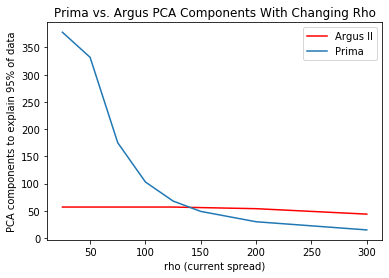

In [37]:
print("prima shapes, ", [v[1] for v in prima_pca_shapes])
print("argus shapes, ", [v[1] for v in argus_pca_shapes])
plt.plot(rhos, [v[1] for v in argus_pca_shapes], 'r', rhos, [v[1] for v in prima_pca_shapes])
plt.ylabel("PCA components to explain 95% of data")
plt.xlabel("rho (current spread)")
plt.title("Prima vs. Argus PCA Components With Changing Rho")
plt.legend(("Argus II", "Prima"))

In [ ]:
import pickle
import os 
import gzip 
# 
# GENERATE PLOT OF THE PCA DATA W/AXONMAP
#
percent = 0.95

argus_pca_shapes = []
prima_pca_shapes = []
for rho in rhos:
    argus_percepts_path = os.path.join(basedir, "argus_scoreboard_rho%d.pickle.gz" % rho)
    prima_percepts_path = os.path.join(basedir, "prima_scoreboard_rho%d.pickle.gz" % rho)
    with gzip.open(argus_percepts_path, "rb") as f:
        argus_percepts = pickle.load(f)
    print("loaded argus percepts for rho %d, size: %s" % (rho, str(np.array(argus_percepts).shape)))
    with gzip.open(prima_percepts_path, "rb") as f:
        prima_percepts = pickle.load(f)
    print("loaded prima percepts for rho %d, size: %s" % (rho, str(np.array(prima_percepts).shape)))
    
    argus_pca_components, _ = run_pca(argus_percepts, percent)
    argus_pca_shapes.append(argus_pca_components.shape)
    print("\targus pca shape: " + str(argus_pca_components.shape))
    prima_pca_components, _ = run_pca(prima_percepts, percent)
    prima_pca_shapes.append(prima_pca_components.shape)
    print("\tprima pca shape: " + str(prima_pca_components.shape))